# Not Scaled Data

In [252]:
import pandas as pd
xls = pd.ExcelFile("Фрустрация.xlsx")
data = pd.read_excel(xls, xls.sheet_names)    

In [253]:
keys = [' E', ' E1', ' e_', ' M', ' M1', ' m_', ' I', ' I1', ' i_']

keys1 = [[' E', ' E1', ' e_'],
         [' M', ' M1', ' m_'],
         [' I', ' I1', ' i_']]

keys2 = [[' E', ' M', ' I'],
        [' E1', ' M1', ' I1'],
        [' e_', ' m_', ' i_']]
def get_y(keys, data, init_keys = keys):
    y = []
    for ind, i in enumerate(init_keys):
        for ind1, j in enumerate(keys):
            if i in j:
                y.append(ind1 * np.ones(len(data[i])))
    return np.hstack(y)

In [254]:
col = list(data[keys[0]].columns)
col

['Unnamed: 0',
 'Число восклицательных знаков',
 'Число вопросительных знаков',
 'Число слов',
 'Число символов',
 'Число уникальных слов',
 'Число клауз',
 'Число предложений',
 'Число знаков препинания',
 'Средняя длина предложения (в количестве слов)',
 'Число уникальных слов / Число слов',
 'Число знаков пунктуации / Число слов',
 'Тональность слов (по округленным значениям)',
 'Тональность слов (по усредненным значениям)',
 'Максимальная глубина синтаксического дерева',
 'Минимальная глубина синтаксического дерева',
 'Средняя глубина синтаксического дерева',
 'Число отрицательных приставок и форм (не,ни,бес,без) / Число слов',
 'Средняя длина слов (в количестве символов)',
 'Доля прописных символов',
 'Доля инфинитивов',
 'Доля глаголов прошедшего времени',
 'Причастия + деепричастия / Число предложений',
 'Доля глаголов 1 лица',
 'Доля глаголов 2 лица',
 'Доля глаголов 3 лица',
 'Доля глаголов прошедшего времени, первого лица, единственного числа',
 'Доля местоимений 1 лица',
 'Д

In [259]:
def extract(list_of_texts):
    res = []
    for s in list_of_texts:
        k = 0
        for c in s:
            if c.islower():
                k += 1
        res.append(k/len(s))
    
    return pd.DataFrame({"Доля":res})

In [260]:
import json
with open("p3_texts.json", "r") as f:
    texts = f.read()
    texts = json.loads(texts)
    f.close()
print(texts.keys())
for key in keys:
    if key[-1] == '1':
        key1 = key[:-1] + "'"
    else:
        key1 = key
    data[key] = data[key].join( extract(texts['P3:' + key1]), rsuffix = "___")

dict_keys(['P3: E', 'P3: M', 'P3: m_', 'P3: e_', "P3: I'", "P3: E'", 'P3: i_', "P3: M'", 'P3: инф', 'P3: I', 'P3: n ("надо")'])


In [261]:
import numpy as np
from sklearn.preprocessing import scale
X = np.vstack([data[i].values for i in keys])
X = X[:, 1:]
y1 = get_y(keys1, data)
y2 = get_y(keys2, data)

In [262]:
print("Число слов", X[:, 2].mean())

Число слов 36.49063670411985


In [263]:
print("Число предложений", X[:, 6].mean())

Число предложений 3.4569288389513106


In [264]:
print("Число символов", X[:, 3].mean())

Число символов 188.49812734082397


In [265]:
X[:,4].mean()

29.790262172284645

## The First Union

In [284]:
class my_preproc:
    def __init__(self, ind = [2]):
        self.ind = ind
        self.M = None
    
    def fit(self, X, y):
        self.M = [X[:, i].mean() for i in self.ind]
        return self
        
    def f(self, q):
        return q
    def transform(self, X):
        return np.hstack([X/i for i in self.M])

In [285]:
from sklearn.pipeline import Pipeline

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures

from sklearn.feature_selection import SelectFromModel

from sklearn.linear_model import LogisticRegression, Lasso

model = Pipeline([
    ('my_preproc', my_preproc([2])),
    ('scaler', StandardScaler()),
    ('select', SelectFromModel(LogisticRegression(C = 1, 
                                                        penalty="l1", 
                                                        multi_class = 'ovr', 
                                                        class_weight = "balanced",
                                                        solver = 'liblinear'))),
    ('main_model', LogisticRegression(C = 0.01,
                                      penalty = "l2",
                                      solver = "liblinear",
                                      class_weight = "balanced",
                                      multi_class = "ovr",
                                      max_iter = 100))
])

In [286]:
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.utils import shuffle

from sklearn.metrics import f1_score, recall_score, precision_score, make_scorer
scoring = ["f1_macro", "recall_macro", "precision_macro"]

s = 0
N = 100
full_res = {}
for key in scoring:
    full_res[key] = []
for i in range(N):
    X_, y = shuffle(X, y1)
    res = cross_validate(model, X_, y, cv = 3, scoring = scoring)
    for key in scoring:
        full_res[key].append(res['test_' + key])

In [287]:
for key in scoring:
    print(key, np.array(full_res[key]).mean(), np.array(full_res[key]).std())

f1_macro 0.4015636540297925 0.05271696364902278
recall_macro 0.45491154100529096 0.08575341817219528
precision_macro 0.3988553763366995 0.04626303745073582


In [295]:
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.utils import shuffle

from sklearn.metrics import f1_score, recall_score, precision_score, make_scorer
from sklearn.model_selection import train_test_split
scoring = ["f1_macro", "recall_macro", "precision_macro"]

X_train, X_test, y_train, y_test = train_test_split(X,y1)
model.fit(X_train, y_train)
print("f1", f1_score(y_test, model.predict(X_test), average = "macro"))
print("recall", recall_score(y_test, model.predict(X_test), average = "macro"))
print("precision", precision_score(y_test, model.predict(X_test), average = "macro"))

f1 0.4319573255743469
recall 0.48333333333333334
precision 0.41827697262479874


In [296]:
import shap
explainer = shap.KernelExplainer(model.predict_proba, X_train, link="logit")
shap_values = explainer.shap_values(X_train)

Using 200 background data samples could cause slower run times. Consider using shap.kmeans(data, K) to summarize the background as K weighted samples.


/home/elias/anaconda3/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
/home/elias/anaconda3/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
/home/elias/anaconda3/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior wil

/home/elias/anaconda3/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
/home/elias/anaconda3/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
/home/elias/anaconda3/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior wil

/home/elias/anaconda3/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
/home/elias/anaconda3/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
/home/elias/anaconda3/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior wil

/home/elias/anaconda3/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
/home/elias/anaconda3/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
/home/elias/anaconda3/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior wil

/home/elias/anaconda3/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
/home/elias/anaconda3/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
/home/elias/anaconda3/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior wil

/home/elias/anaconda3/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
/home/elias/anaconda3/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
/home/elias/anaconda3/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior wil

/home/elias/anaconda3/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
/home/elias/anaconda3/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
/home/elias/anaconda3/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior wil

/home/elias/anaconda3/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
/home/elias/anaconda3/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
/home/elias/anaconda3/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior wil

/home/elias/anaconda3/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
/home/elias/anaconda3/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
/home/elias/anaconda3/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior wil

/home/elias/anaconda3/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
/home/elias/anaconda3/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
/home/elias/anaconda3/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior wil

/home/elias/anaconda3/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
/home/elias/anaconda3/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
/home/elias/anaconda3/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior wil

/home/elias/anaconda3/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
/home/elias/anaconda3/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
/home/elias/anaconda3/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior wil

/home/elias/anaconda3/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
/home/elias/anaconda3/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
/home/elias/anaconda3/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior wil

/home/elias/anaconda3/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
/home/elias/anaconda3/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
/home/elias/anaconda3/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior wil

/home/elias/anaconda3/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
/home/elias/anaconda3/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
/home/elias/anaconda3/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior wil

/home/elias/anaconda3/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
/home/elias/anaconda3/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
/home/elias/anaconda3/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior wil

/home/elias/anaconda3/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
/home/elias/anaconda3/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
/home/elias/anaconda3/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior wil

/home/elias/anaconda3/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
/home/elias/anaconda3/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
/home/elias/anaconda3/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior wil

/home/elias/anaconda3/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
/home/elias/anaconda3/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
/home/elias/anaconda3/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior wil

/home/elias/anaconda3/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
/home/elias/anaconda3/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
/home/elias/anaconda3/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior wil

/home/elias/anaconda3/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
/home/elias/anaconda3/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
/home/elias/anaconda3/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior wil

/home/elias/anaconda3/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
/home/elias/anaconda3/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
/home/elias/anaconda3/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior wil

/home/elias/anaconda3/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
/home/elias/anaconda3/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
/home/elias/anaconda3/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior wil

/home/elias/anaconda3/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
/home/elias/anaconda3/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
/home/elias/anaconda3/lib/python3.7/site-packages/shap/explainers/kernel.py:555: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior wil

In [297]:
shap.initjs()

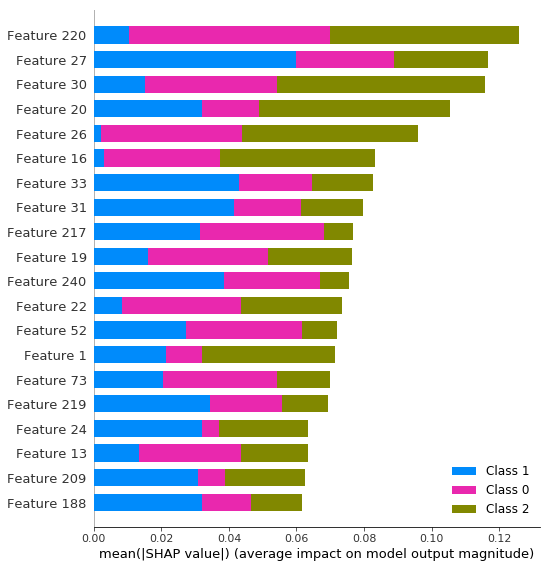

In [298]:
shap.summary_plot(shap_values, X_train)

In [415]:
keys = [20, 39, 27, 17, 33, 188, 16, 217, 24, 29, 37, 58, 50, 223, 34, 209, 30, 79, 43, 218]
keys1 = [217, 30, 220, 27, 20, 26, 31, 66, 1, 33, 37, 57, 223, 22, 24, 13, 19, 28, 232, 90]
keys2 = [220, 27, 30, 20, 26, 16, 33, 31, 217, 19, 240, 22, 52, 1, 73, 219, 24, 13, 209, 188]
np.array(col)[[i for i in keys2[:10] if i in keys1[:10]]]

array(['Синтакс. связь: conj', 'Доля местоимений 1 лица',
       'Доля местоимений 1 лица мн. числа', 'Доля инфинитивов',
       'Доля глаголов прошедшего времени, первого лица, единственного числа',
       'Коэффициент логической связности',
       'Доля местоимений 1 лица ед. числа', 'Синтакс. связь: cc'],
      dtype='<U75')

In [426]:
import matplotlib.pylab as plt
%matplotlib notebook

In [436]:
main_keys = keys2[:6]
classes = [0, 1, 2]
for i in main_keys:
    print("\item " + col[i])
key = main_keys.pop(0)
print(key)
folder_results = "first_union_"

\item Синтакс. связь: conj
\item Доля местоимений 1 лица
\item Доля местоимений 1 лица мн. числа
\item Доля инфинитивов
\item Доля глаголов прошедшего времени, первого лица, единственного числа
\item Средняя глубина синтаксического дерева
220


Синтакс. связь: conj


<IPython.core.display.Javascript object>


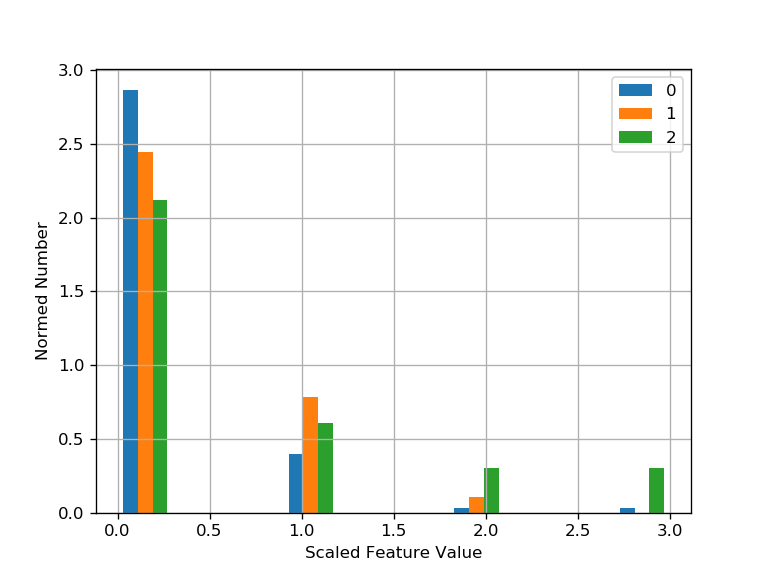

In [428]:
%matplotlib notebook
print(col[key])
x = []
for i in classes:
    x.append([j for ind, j in enumerate(X[:, key]) if y1[ind]==i])
plt.hist(x, density = True)
#plt.xticks(np.linspace(-1,1, 11))
plt.grid()
plt.xlabel('Scaled Feature Value')
plt.ylabel('Normed Number')
plt.legend(classes)
plt.show()
plt.savefig('Images/' + folder_results +str(len(main_keys)) + '.eps')
key = main_keys.pop(0)

Доля местоимений 1 лица


<IPython.core.display.Javascript object>


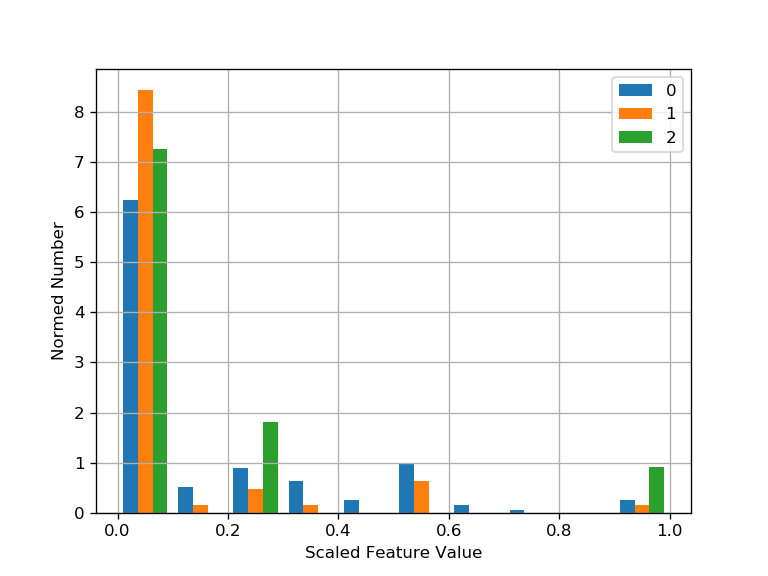

In [429]:
%matplotlib notebook
print(col[key])
x = []
for i in classes:
    x.append([j for ind, j in enumerate(X[:, key]) if y1[ind]==i])
plt.hist(x, density = True)
#plt.xticks(np.linspace(-1,1, 11))
plt.grid()
plt.xlabel('Scaled Feature Value')
plt.ylabel('Normed Number')
plt.legend(classes)
plt.show()
plt.savefig('Images/' + folder_results +str(len(main_keys)) + '.eps')
key = main_keys.pop(0)

Доля местоимений 1 лица мн. числа


<IPython.core.display.Javascript object>


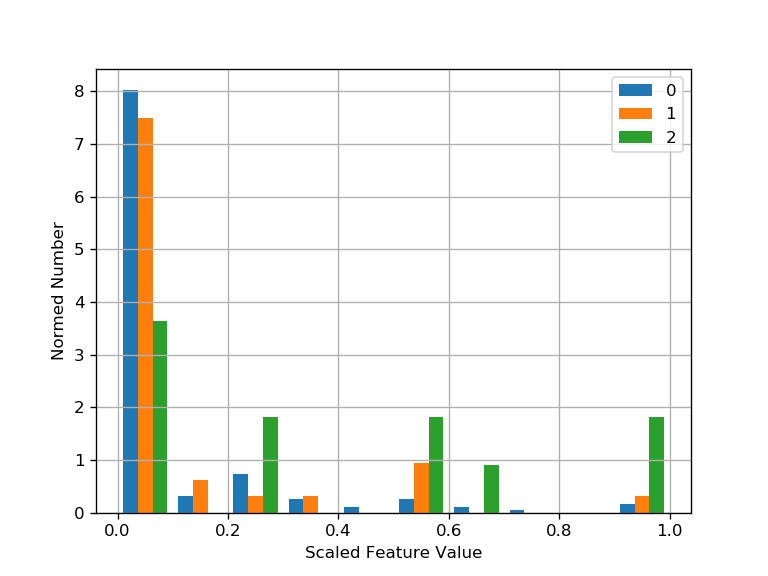

In [430]:
%matplotlib notebook
print(col[key])
x = []
for i in classes:
    x.append([j for ind, j in enumerate(X[:, key]) if y1[ind]==i])
plt.hist(x, density = True)
#plt.xticks(np.linspace(-1,1, 11))
plt.grid()
plt.xlabel('Scaled Feature Value')
plt.ylabel('Normed Number')
plt.legend(classes)
plt.show()
plt.savefig('Images/' + folder_results +str(len(main_keys)) + '.eps')
key = main_keys.pop(0)

Доля инфинитивов


<IPython.core.display.Javascript object>


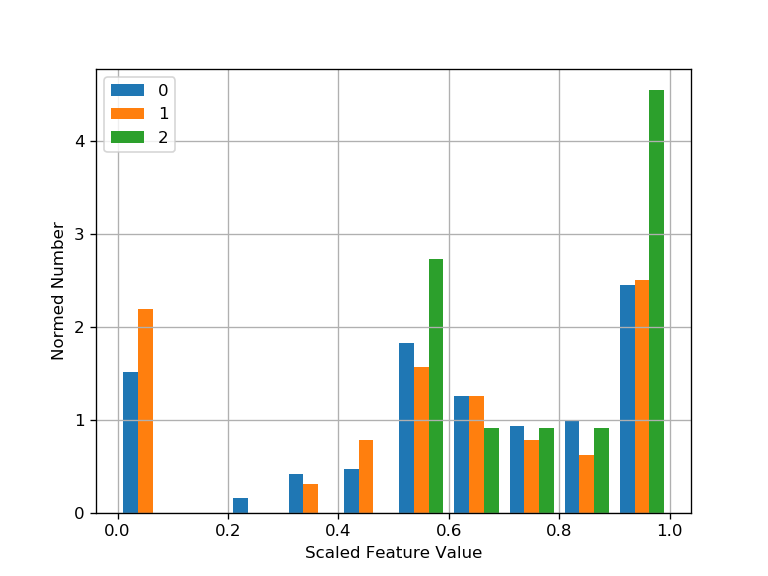

In [431]:
%matplotlib notebook
print(col[key])
x = []
for i in classes:
    x.append([j for ind, j in enumerate(X[:, key]) if y1[ind]==i])
plt.hist(x, density = True)
#plt.xticks(np.linspace(-1,1, 11))
plt.grid()
plt.xlabel('Scaled Feature Value')
plt.ylabel('Normed Number')
plt.legend(classes)
plt.show()
plt.savefig('Images/' + folder_results +str(len(main_keys)) + '.eps')
key = main_keys.pop(0)

Доля глаголов прошедшего времени, первого лица, единственного числа


<IPython.core.display.Javascript object>


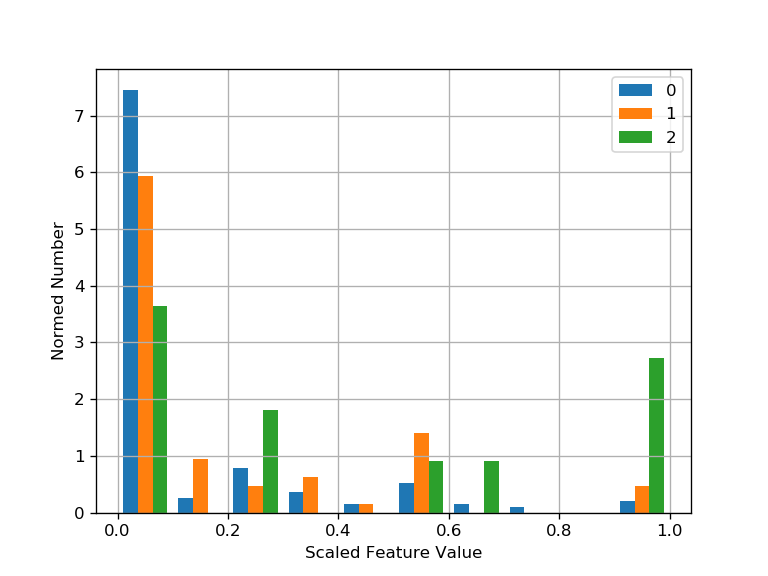

In [432]:
%matplotlib notebook
print(col[key])
x = []
for i in classes:
    x.append([j for ind, j in enumerate(X[:, key]) if y1[ind]==i])
plt.hist(x, density = True)
#plt.xticks(np.linspace(-1,1, 11))
plt.grid()
plt.xlabel('Scaled Feature Value')
plt.ylabel('Normed Number')
plt.legend(classes)
plt.show()
plt.savefig('Images/' + folder_results +str(len(main_keys)) + '.eps')
key = main_keys.pop(0)

Средняя глубина синтаксического дерева


<IPython.core.display.Javascript object>


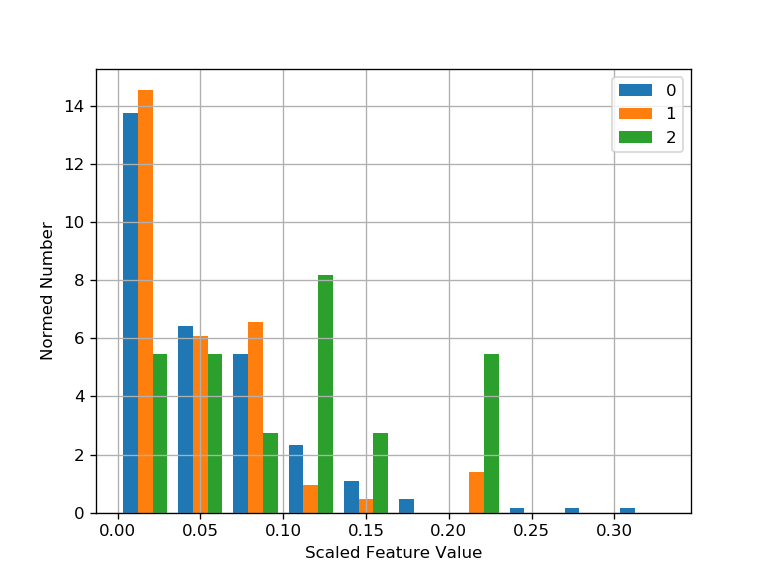

In [433]:
%matplotlib notebook
print(col[key])
x = []
for i in classes:
    x.append([j for ind, j in enumerate(X[:, key]) if y1[ind]==i])
plt.hist(x, density = True)
#plt.xticks(np.linspace(-1,1, 11))
plt.grid()
plt.xlabel('Scaled Feature Value')
plt.ylabel('Normed Number')
plt.legend(classes)
plt.show()
plt.savefig('Images/' + folder_results +str(len(main_keys)) + '.eps')